# LIDA - Automatic Generation of Visualizations and Infographics using Large Language Models

LIDA is a library for generating data visualizations and data-faithful infographics. LIDA is grammar agnostic (will work with any programming language and visualization libraries e.g. matplotlib, seaborn, altair, d3 etc) and works with multiple large language model providers (OpenAI, PaLM, Cohere, Huggingface). Details on the components of LIDA are described in the [paper here](https://arxiv.org/abs/2303.02927) and in this tutorial [notebook](notebooks/tutorial.ipynb). See the project page [here](https://microsoft.github.io/lida/) for updates!.



## Getting Started | Installation

```bash 
pip install lida
```

If you intend to use lida with local huggingface models, you will need to install the `transformers` library. 

```bash
pip install lida[transformers]
```

## The LIDA Python API

Lida offers a manager class that exposes core functionality of the LIDA system. This tutorial will show you how to use the manager class to create visualizations based on a dataset.

### Multiple LLM Backends
LIDA supports multiple LLM backends such as `openai`, `cohere`, `palm`, `huggingface` etc. You can switch between backends by setting the `text_gen` parameter in the `Manager` class. By default, LIDA uses the `openai` backend. For a list of supported models and how to configure them, see the [llmx documentation](https://github.com/victordibia/llmx).

```python

from lida import llm

text_gen = llm("openai") # for openai
text_gen = llm(provider="openai", api_type="azure", api_base=os.environ["AZURE_OPENAI_BASE"], api_key=os.environ["AZURE_OPENAI_API_KEY"],    api_version="2023-07-01-preview") # for azure openai
text_gen = llm("cohere") # for cohere
text_gen = llm("palm") # for palm
text_gen = llm(provider="hf", model="uukuguy/speechless-llama2-hermes-orca-platypus-13b", device_map="auto")

lida = Manager(text_gen=text_gen)
```

Note that you can set your llm keys as follows

```bash
export OPENAI_API_KEY=<your key>
export COHERE_API_KEY=<your key>
# for PaLM
export PALM_SERVICE_ACCOUNT_KEY_FILE=<path to gcp service account key file>
export PALM_PROJECT_ID=<your gcp project id>
```
#### Azure OpenAI
```python
from llmx.generators.text.openai_textgen import OpenAITextGenerator
from llmx.generators.text.textgen import sanitize_provider

provider = sanitize_provider("azureopenai")
models = {}

text_gen = OpenAITextGenerator(
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    api_base=os.environ["AZURE_OPENAI_BASE"],
    provider=provider,
    models=models
)
lida = Manager(text_gen=text_gen)
```


### Summarization Methods 
The summarizer module works takes an `summary_method` argument which determines if the base summary is enriched by an LLM. By default, the `summary_method` argument is set to `default` for a base summary (statistics etc). Set it to `llm` to enrich/annotate the base summary with an llm.

### Caching 
Each manager method takes a [`textgen_config`](https://github.com/victordibia/llmx/blob/7c0fc093d1b8780ebebc7e080f5c63991514038b/llmx/datamodel.py#L22C10-L22C10) argument which is a dictionary that can be used to configure the text generation process (with parameters for model, temperature, max_tokens, topk etc). One of the keys in this dictionary is `use_cache`. If set to `True`, the manager will cache the generated text associated with that method. Use for speedup and to avoid hitting API limits.


In [1]:
# !pip install lida 
# !pip install lida[infographics] # for infographics support

In [2]:
from lida import Manager, TextGenerationConfig , llm  

## Summarize Data, Generate Goals

In [3]:
lida = Manager(text_gen = llm("openai", api_key=None)) # !! api key
textgen_config = TextGenerationConfig(n=1, temperature=0.5, model="gpt-3.5-turbo-0301", use_cache=True)

summary = lida.summarize("https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv", summary_method="default", textgen_config=textgen_config)  
goals = lida.goals(summary, n=2, textgen_config=textgen_config)

for goal in goals:
    display(goal)


### Goal 0
---
**Question:** What is the average retail price and dealer cost of the different car types?

**Visualization:** `grouped bar chart of average retail price and dealer cost by car type`

**Rationale:** This visualization will allow us to compare the average retail price and dealer cost of different car types. By comparing the two, we can see which car types have a higher markup and which ones have a smaller markup, which can help inform pricing decisions. The 'Type' column and the 'Retail_Price' and 'Dealer_Cost' columns will be used for this visualization.



### Goal 1
---
**Question:** What is the relationship between engine size and horsepower?

**Visualization:** `scatter plot of engine size vs horsepower`

**Rationale:** This visualization will allow us to see the relationship between engine size and horsepower. By examining this relationship, we can determine if there is a correlation between the two and if engine size is a good predictor of horsepower. This can help inform decisions around engine design and performance. The 'Engine_Size__l_' and 'Horsepower_HP_' columns will be used for this visualization.


## Generate Goals based on a Persona

In [15]:
# goals can also be based on a persona 
persona = "a pirate looking to move fromt the sea to the land"
personal_goals = lida.goals(summary, n=2, persona=persona, textgen_config=textgen_config)
for goal in personal_goals:
    display(goal)


### Goal 0
---
**Question:** What is the distribution of Retail Price and Dealer Cost for different car types?

**Visualization:** `Grouped bar chart of Retail Price and Dealer Cost by car type`

**Rationale:** This visualization will help the pirate understand the differences in pricing between different car types. By comparing the Retail Price and Dealer Cost of different car types, the pirate can make informed decisions on which car types to invest in for resale. The grouped bar chart is the best visualization for comparing quantities across different categories.



### Goal 1
---
**Question:** What is the relationship between Engine Size, Horsepower, and Miles Per Gallon?

**Visualization:** `Scatter plot of Engine Size vs Horsepower, with color encoding for Miles Per Gallon`

**Rationale:** This visualization will help the pirate understand the trade-offs between engine size, horsepower, and fuel efficiency. By plotting Engine Size and Horsepower on the x and y axes, and using color encoding for Miles Per Gallon, the pirate can see which cars have high horsepower and engine size, but low fuel efficiency. This will help the pirate make informed decisions on which cars to invest in for resale, based on their target market's preferences for power and fuel efficiency.


## Generate Visualizations

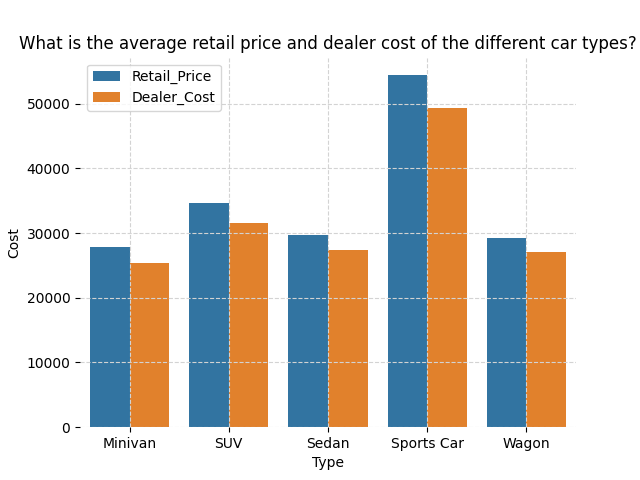

In [5]:
i = 0
library = "seaborn"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library)  
charts[0]

### Generate visualization via a "user query"   

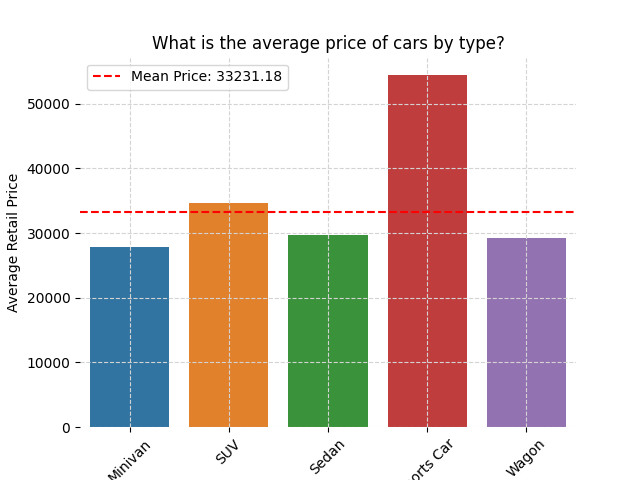

In [6]:
user_query = "What is the average price of cars by type?"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)  
charts[0]

# VizOps

Given that LIDA represents visualizations as code,
the VISGENERATOR also implements submodules
to perform operations on this representation. 

This includes 
- **Natural language based visualization refinement**: Provides a conversational api to iteratively
4Execution in a sandbox environment is recommended.
refine generated code (e.g., translate chart t hindi
. . . zoom in by 50% etc) which can then be executed to generate new visualizations.
- **Visualization explanations and accessibility**:
Generates natural language explanations (valuable
for debugging and sensemaking) as well as accessibility descriptions (valuable for supporting users
with visual impairments).

- **Visualization code self-evaluation and repair**:
Applies an LLM to self-evaluate generated code on
multiple dimensions (see section 4.1.2).

- **Visualization recommendation**: Given some context (goals, or an existing visualization), recommend additional visualizations to the user (e.g., for
comparison, or to provide additional perspectives).



## Natural language based visualization refinement 

Given some code, modify it based on natural language instructions. This yields a new code snippet that can be executed to generate a new visualization.

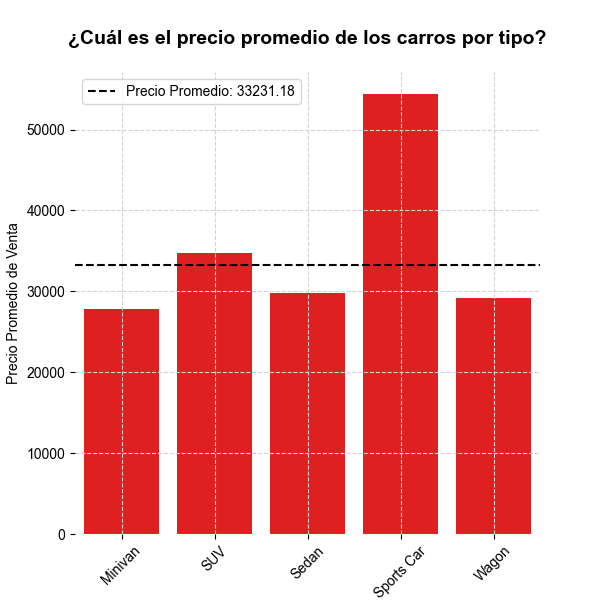

In [7]:
code = charts[0].code
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True)
instructions = ["make the chart height and width equal", "change the color of the chart to red", "translate the chart to spanish"]
edited_charts = lida.edit(code=code,  summary=summary, instructions=instructions, library=library, textgen_config=textgen_config)
edited_charts[0]

## Visualization explanations and accessibility

In [8]:
explanations = lida.explain(code=code, textgen_config=textgen_config) 
for row in explanations[0]:
    print(row["section"]," ** ", row["explanation"])

accessibility  **  The plot is a bar chart that shows the average retail price of cars by type. The x-axis represents the different types of cars, while the y-axis represents the average retail price. The chart uses different colors to represent the different types of cars. The chart has a title that describes the purpose of the chart, and the axes have labels that describe what they represent. The chart is accessible to people with color blindness because it uses different shades of the same color to represent the different types of cars.
transformation  **  This section of the code groups the data by the 'Type' column and calculates the mean of the 'Retail_Price' column for each group. The resulting data is stored in a new DataFrame called 'grouped_data'.
visualization  **  This section of the code creates the bar chart visualization. The 'sns.barplot' function is used to create the bar chart using the 'grouped_data' DataFrame. The 'plt.axhline' function is used to add a horizontal l

## Visualization code self-evaluation and repair

In [9]:
evaluations = lida.evaluate(code=code,  goal=goals[i], textgen_config=textgen_config, library=library)[0] 
for eval in evaluations:
    print(eval["dimension"], "Score" ,eval["score"], "/ 10")
    print("\t", eval["rationale"][:200])
    print("\t**********************************")

bugs Score 10 / 10
	 The code is free of bugs, syntax errors, or typos. It will compile without issues.
	**********************************
transformation Score 10 / 10
	 The data is appropriately transformed by grouping the data by Type and calculating the mean of Retail_Price. This is appropriate for the visualization type (barplot) and the specified goal.
	**********************************
compliance Score 10 / 10
	 The code meets the specified goal of showing the average retail price of different car types. The plot is easy to read and understand.
	**********************************
type Score 10 / 10
	 The visualization type (barplot) is appropriate for showing the mean of a continuous variable (Retail_Price) across a categorical variable (Type). A different visualization type is not more effective 
	**********************************
encoding Score 10 / 10
	 The data is encoded appropriately by mapping the categorical variable (Type) to the x-axis and the continuous variable (Re

## Visualization Recommendation

In [10]:
textgen_config = TextGenerationConfig(n=2, temperature=0.2, use_cache=True)
recommended_charts =  lida.recommend(code=code, summary=summary, n=2,  textgen_config=textgen_config)

Recommended 1 charts


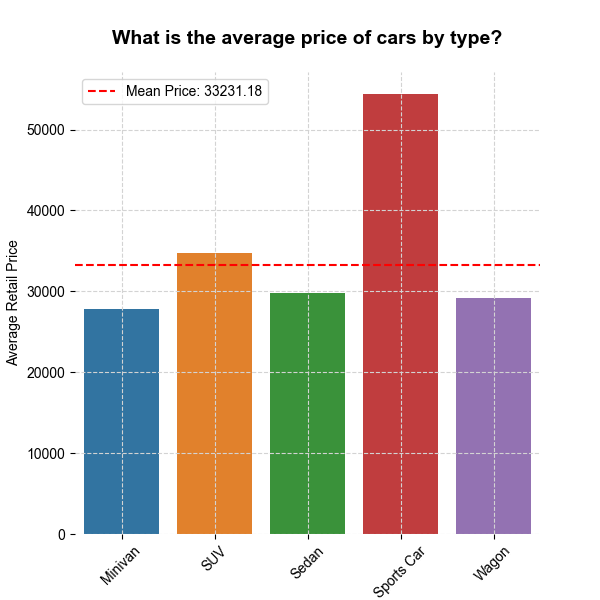

In [11]:
print(f"Recommended {len(recommended_charts)} charts")
for chart in recommended_charts:
    display(chart) 

## Infographics (Beta)

- Explores using LIDA to generate infographics from an existing visualization 
- Uses the `peacasso` package, and loads open source stable diffusion models 
- You will need to run `pip install lida[infographics]` to install the required dependencies.
- Currently work in progress (work being done to post process infographics with chart axis and title overlays from the original visualization, add presets for different infographic styles, and add more stable diffusion models)


In [12]:
# !pip install lida[infographics] 
# ensure you have a GPU runtime

In [13]:
# infographics = lida.infographics(visualization = edited_charts[0].raster, n=1, style_prompt="pastel art, green pearly rain drops, highly detailed, no blur, white background")

In [14]:
# from lida.utils import plot_raster
# plot_raster([edited_charts[0].raster, infographics["images"][0]]) 